# 過去30日間の各海釣り施設の釣果数

## モジュールのインポート

In [1]:
# モジュールのインポート

import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import datetime
import jpholiday
import sqlite3
import seaborn as sns

# グラフサイズ変更。既定より大きくする

plt.rcParams['figure.figsize'] = [15, 10]

# seaborn グラフにグリッド線を追加

sns.set()
sns.set_style("whitegrid", {'grid.linestyle': '--'})

## データのロードと変換

In [2]:
# プロジェクトディレクトリ以外でjupyter notebook を実行した場合は、以下コマンドで、
# SQLLite3データベースの絶対パスを確認し、次の sqlite3.connect({パス名})文で、
# 指定してください。
from piersfan.config import Config
print(Config.get_db_path())

/home/psadmin/work/blog/choka/fishing-piers-fan/data/fishing_result.db


In [13]:
# 大黒、アジ以外の魚種で、SQLite3データベースを検索

conn = sqlite3.connect("../data/fishing_result.db")
sql = '''
select
    r.Date,
    r.Point,
    r.Species,
    r.Count,
    r.SizeMin,
    r.SizeMax,
    c.WaterTemp,
    c.Quantity
from
    fishing_results r,
    fishing_comments c
where
    r.Date = c.Date
    and r.Point = c.Point
    and r.Date >= (SELECT datetime(max(Date), '-30 day') from fishing_results)
'''
df=pd.read_sql_query(sql, conn)

# 土日祝日化判定列を追加

df['Date'] = pd.to_datetime(df.Date)
def isBizDay(Date):
    if Date.weekday() >= 5 or jpholiday.is_holiday(Date):
        return 'Holiday'
    else:
        return 'WeekDay'

df['BizDay'] = df.apply(lambda x: isBizDay(x.Date), axis=1)

# 日付を索引にセットし、年、月カラムを追加

df = df.set_index('Date')
df['Year'] = df.index.year
df['Month'] = df.index.month
df['DayOfYear'] = df.index.dayofyear
df['WeekOfYear'] = df.index.strftime('%U').astype(int) # df3.index.week
df.head()

,Point,Species,Count,SizeMin,SizeMax,WaterTemp,Quantity,BizDay,Year,Month,DayOfYear,WeekOfYear
Date,,,,,,,,,,,,
2021-04-01,daikoku,アジ,134,13.0,25.0,16.0,232.0,WeekDay,2021,4,91,13
2021-04-01,daikoku,イワシ,1345,10.0,15.0,16.0,232.0,WeekDay,2021,4,91,13
2021-04-01,daikoku,ウミタナゴ,3,20.0,22.0,16.0,232.0,WeekDay,2021,4,91,13
2021-04-01,daikoku,カサゴ,63,16.0,26.0,16.0,232.0,WeekDay,2021,4,91,13
2021-04-01,daikoku,クロダイ,14,32.0,50.0,16.0,232.0,WeekDay,2021,4,91,13


In [14]:
# 日本語の文字化け対策のため、魚種をローマ字に変換

def get_spieces_alphabet(spieces):
    if spieces == 'アジ':
        return 'Aji'
    if spieces == 'クロダイ':
        return 'Kurodai'
    elif spieces == 'メジナ':
        return 'Mejina'
    elif spieces == 'メバル':
        return 'Mebaru'
    elif spieces == 'カサゴ':
        return 'Kasago'
    else:
        return 'Etc'

df['Species'] = df.apply(lambda x: get_spieces_alphabet(x.Species), axis=1)

In [15]:
# 代表として設定した魚種以外は取り除く
df2 = df[df.Species!='Etc']

<AxesSubplot:xlabel='Date', ylabel='WaterTemp'>

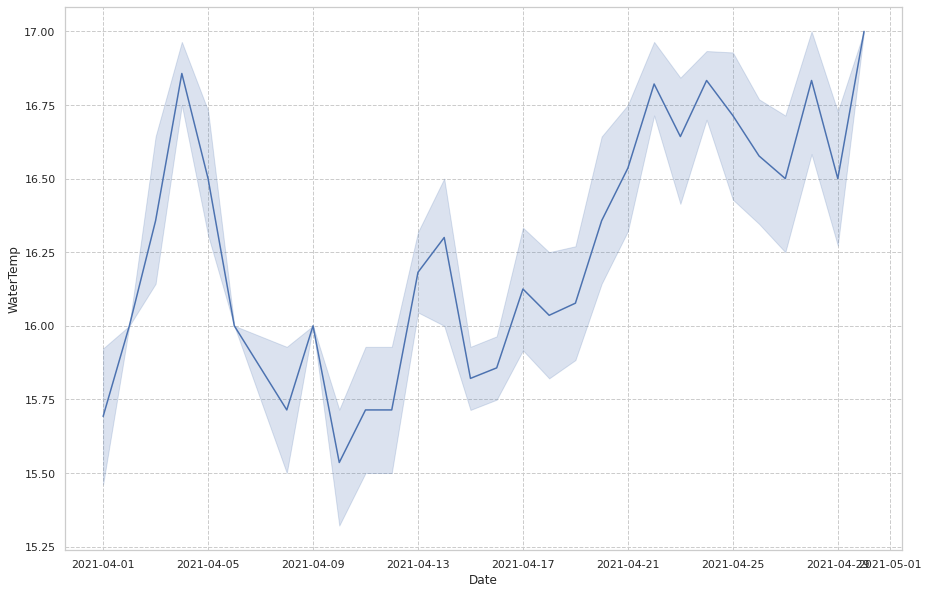

In [16]:
# 海水温の変化
sns.lineplot(data=df2, x="Date", y="WaterTemp")

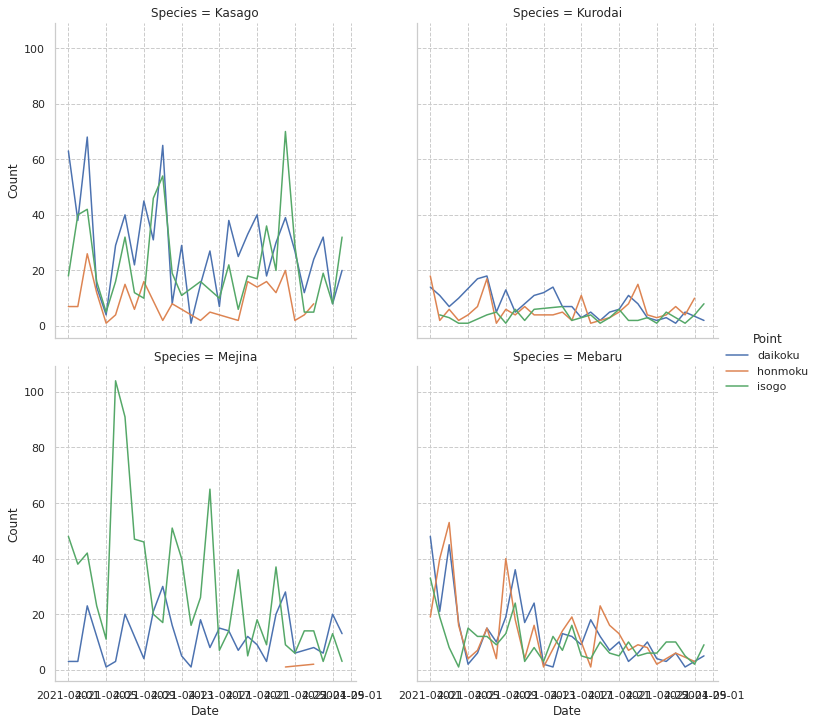

In [22]:
# アジの釣果数
sns.relplot(data=df2.query('Species!="Aji"'), x="Date", y="Count", col="Species", hue="Point", kind="line",
           col_wrap=2)

<AxesSubplot:xlabel='Date', ylabel='SizeMax'>

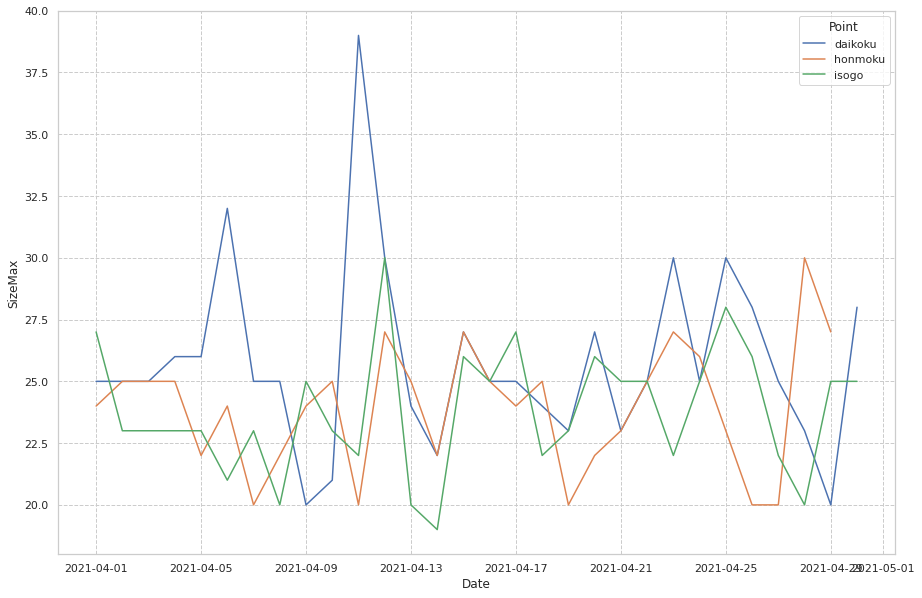

In [24]:
# アジの釣果サイズ（最大）
sns.lineplot(data=df2.query('Species=="Aji"'), x="Date", y="SizeMax", hue="Point")

<AxesSubplot:xlabel='Date', ylabel='SizeMax'>

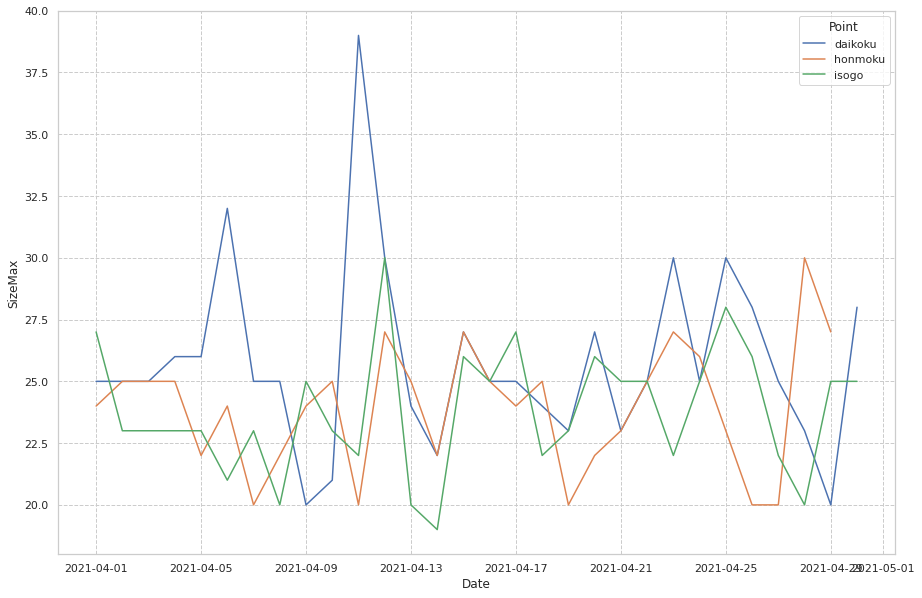

In [8]:
# アジの釣果サイズ（最大）
sns.lineplot(data=df2.query('Species=="Aji"'), x="Date", y="SizeMax", hue="Point")

<AxesSubplot:xlabel='Date', ylabel='Count'>

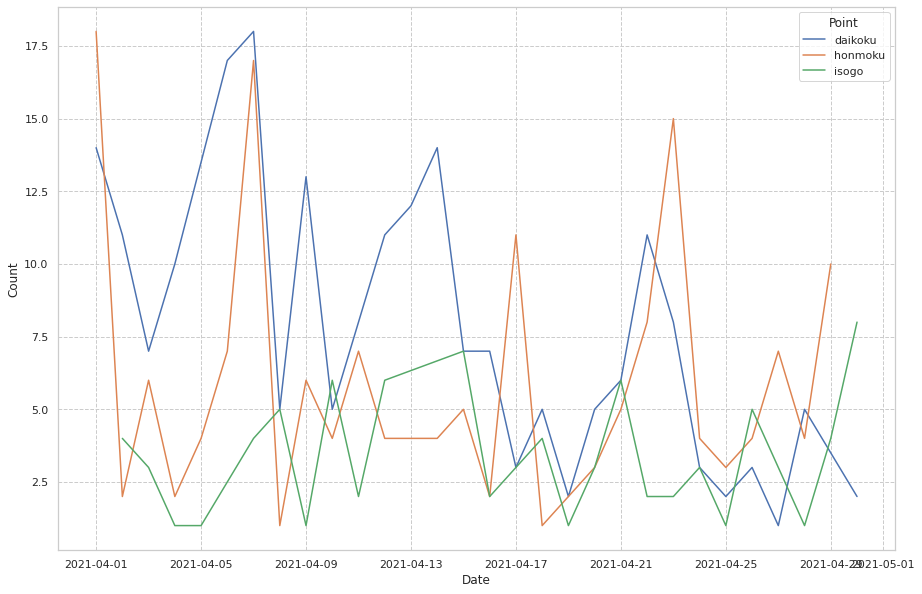

In [9]:
# クロダイの釣果数
sns.lineplot(data=df2.query('Species=="Kurodai"'), x="Date", y="Count", hue="Point")

<AxesSubplot:xlabel='Date', ylabel='SizeMax'>

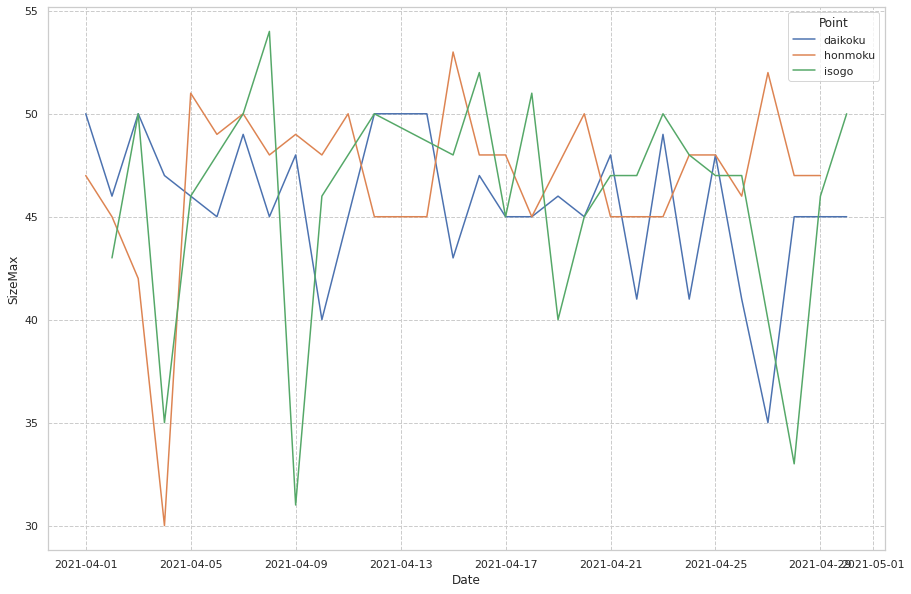

In [10]:
# クロダイの釣果サイズ（最大）
sns.lineplot(data=df2.query('Species=="Kurodai"'), x="Date", y="SizeMax", hue="Point")

<AxesSubplot:xlabel='Species', ylabel='Count'>

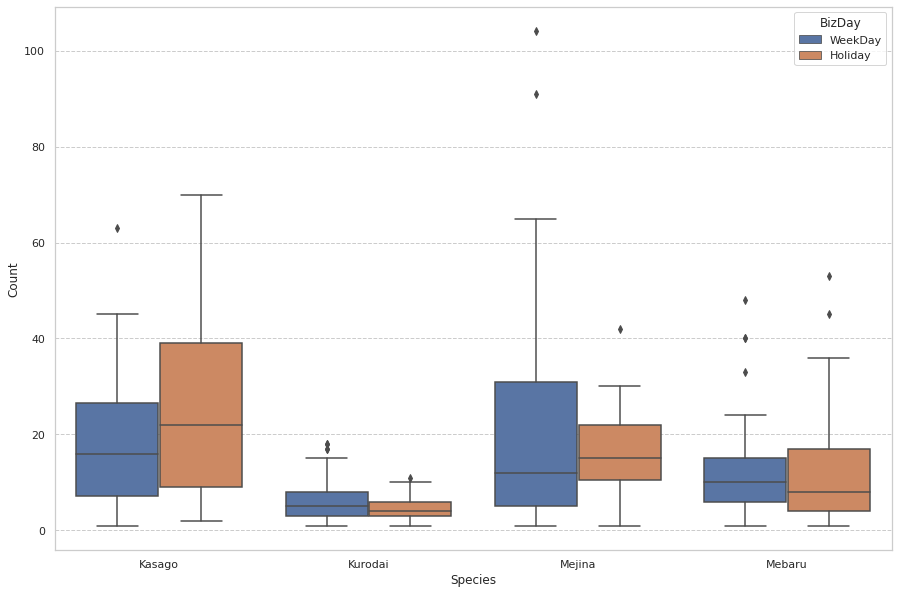

In [25]:
# アジ、その他の魚種の釣果を取り除く

df3 = df.query('Species != "Etc" and Species != "Aji"')

# 平日、休日の違い、魚種別釣果数

sns.boxplot(data=df3, x='Species', y='Count', hue='BizDay')